In [1]:
import numpy as np
from matplotlib.pyplot import *
import lightkurve as lk
import globalDetFunctions as gd
from scipy.signal import hilbert

In [24]:
def getTrimmedACF(f, p, b, W=None, freqBinSize=1, zeromean=True):
    
    fb, pb, bb, dfb, Nbin = gd.binTheSpectrum(f, p, b, freqBinSize)
    
    snr = pb/bb
    
    if W is None:
        W = np.ones_like(fb)
    
    if zeromean:
        snr -= np.nanmean(snr)
    
    lags, acf = fftAcf(fb, snr, W)
    
    # Set the limit to consider in the ACF. This is 3 times the Dnu corresponding
    # to the Nyquist frequency times a bit. Should be enough to include 
    # everything of interest.
    lmax = 3*gd.dnuScale(fb[-1])
    
    idx = (0 < lags) & (lags < lmax)
    
    return lags[idx], acf[idx]


def fftAcf(f, s, W, skip = 1, axis=-1, **kwargs):
    """ Compute ACF using the FFT method
       
    Compute the autocorrelation function (ACF) of 
    an array using NumPy's fast Fourier transform. 

    Parameters
    ----------
    f : array
        Frequency array.
    s : array
        Spectrum to compute the ACF of.
    skip : int
        Factor to use for downsampling the ACF if 
        the full resolution is not required. If you
        want to oversample the ACF skip should be 
        < 1
    axis : int
        Axis of x to use for computing the FFT and
        iFFT, in case x.ndim > 1.
    kwargs : dict
        Additional keywords to be passed to FFT and 
        iFFT.
    """

    F = np.fft.fft(s, axis=axis)
    
    acf = np.real(np.fft.ifft(F*np.conj(F)*W, n = int(len(F)//skip), axis=axis))
    
    df = np.median(np.diff(f))*skip
    
    lags = np.arange(len(acf))*df
       
    return lags[:int(len(F)//(skip*2))], acf[:int(len(F)//(skip*2))]

def envWidth(numax, teff, teff0=5777):
    """ Scaling relation for the envelope width
    
    Currently just a crude estimate. This can probably 
    be improved.
    
    Parameters
    ----------
    numax : float
        Frequency of maximum power of the p-mode envelope.
    teff : float
        Effective temperature of the star
    
    Returns
    -------    
    width : float
        Envelope width in muHz
    
    """
    if teff <= 5600:
        width = 0.66*numax**0.88
    else:
        width = 0.66*numax**0.88*(1+(teff-teff0)*6e-4)

    return width

def makeFilter(i_numax, nu, Nh):
    z = np.zeros_like(nu)
    i0 = i_numax-int(Nh/2)
    i1 = i_numax+int(Nh/2)
    z[i0:i1] = np.hanning(len(z[i0:i1]))
    return z

In [21]:
ID = '10963065'

d = np.genfromtxt(f'/home/nielsemb/work/projects/AndyTgts/{ID}.asc')
cadence = 25 #s
dt = cadence/60/60/24
t = np.arange(len(d))*dt

lc = lk.LightCurve(time=t, flux=d, targetid=ID)

Nyquist = 1./(2*cadence) * 1e6

f, p, pg = gd.makePsd(lc, NyquistScale=1.05)

b = gd.getBkg(f, p, skips = len(f)//1800)  

idx = ~np.isnan(b) & (0 <= f) & (f <= Nyquist)

f, p, b = f[idx], p[idx], b[idx]

fb, pb, bb, dfb, Nbin = gd.binTheSpectrum(f, p, b, freqBinSize = 100)

In [25]:
lags, acf = getTrimmedACF(f, p, b, zeromean=False)

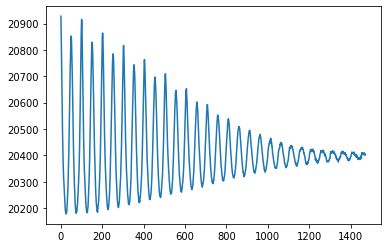

In [28]:
plot(lags, acf)

In [30]:
Teff = 5500

dT = t[-1]-t[0]

dnu = 1/dT/60/60/24*1e6

F = np.real(np.fft.rfft(d, axis=-1))
print(len(F))
nu = np.arange(len(F))*dnu
    
i = 140000

width = envWidth(f[i], Teff) * np.sqrt(2.*np.log(2.))*2

Nh = int(width/np.median(np.diff(nu)))

W = makeFilter(i, nu, Nh)

acf = np.real(np.fft.ifft(F*np.conj(F)*W, n = int(len(F)//1), axis=-1))

C = np.real(acf**2)/np.real(acf[0]**2)#/np.real(acf[0]**2)

lags = np.arange(len(acf))*2*dt*24

lags, C = lags[:int(len(F)//(2))], C[:int(len(F)//(2))]

1262305 1262304.0


In [ ]:
figure(figsize = (16,9))
plot(lags, C)
xlim(4,7)
#ylim(0,0.15)

In [ ]:
#C = np.sqrt(acf**2 + hilbert(acf)**2)

In [ ]:


# Astar = np.real(C)**2/np.real(C[0])**2

# A =  Astar / (3/(2*Nh))#/Nh


# 


# 